In [2]:
'''
(C) 2023 Renata Wong

Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
The molecule tested is H2.
The shadow is constructed based on derandomized Hamiltonian.
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper, ParityMapper

from qiskit.circuit.library import TwoLocal

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 
from qiskit.utils import algorithm_globals

from modified_derandomization import modified_derandomized_classical_shadow
from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1





driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

bk_mapper = BravyiKitaevMapper()
jw_mapper = JordanWignerMapper()
pa_mapper = ParityMapper()
bkencoded_hamiltonian = bk_mapper.map(second_q_op)
jwencoded_hamiltonian = jw_mapper.map(second_q_op)
paencoded_hamiltonian = pa_mapper.map(second_q_op)
#print(bkencoded_hamiltonian)

In [3]:
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data

#print('HAMILTONIAN\n', observables_xyze)

In [4]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 5
ansatz = TwoLocal(num_qubits=system_size, reps=reps, rotation_blocks=['ry', 'rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=False)
ansatz.decompose().draw('mpl')






def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    

    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                  
        qc.measure(reversed(range(system_size)), range(system_size))                      
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after register reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    

    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value

In [12]:
'''
Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
'''

estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
vqe_solver = VQE(estimator, ansatz, SLSQP(maxiter=3000))

calc = GroundStateEigensolver(bk_mapper, vqe_solver)
result = calc.solve(problem)
print(result.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.001832043518416912,
                                                          {}),
                                   'Magnetization': (-7.75015265291612e-05, {}),
                                   'ParticleNumber': (2.0001067026222117, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.3861523139339846, {})},
    'cost_function_evals': 14480,
    'eigenvalue': -1.8499915033930974,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7efbcc25e3a0>,
    'optimal_parameters': {   ParameterVectorElement(θ[70]): -1.565214702637431,
                              ParameterVectorElement(θ[69]): 1.6852924070443394,
                              ParameterVectorElement(θ[68]): 3.2415813749960574,
                              ParameterVectorElement(θ[75]): -4.421152886130877,
            

NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = 1.520034984933042
EXPERIMENT 1: GROUND STATE ENERGY FOUND = 1.521650062536038
EXPERIMENT 2: GROUND STATE ENERGY FOUND = 1.5195817738332182
EXPERIMENT 3: GROUND STATE ENERGY FOUND = 1.5434664885240792
EXPERIMENT 4: GROUND STATE ENERGY FOUND = 1.5147449542558244
EXPERIMENT 5: GROUND STATE ENERGY FOUND = 1.5240803708378983
EXPERIMENT 6: GROUND STATE ENERGY FOUND = 1.5404182003069813
EXPERIMENT 7: GROUND STATE ENERGY FOUND = 1.5246595092240025
EXPERIMENT 8: GROUND STATE ENERGY FOUND = 1.5264463809943487
EXPERIMENT 9: GROUND STATE ENERGY FOUND = 1.5504022202994414
50 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 50}) | 3.378558815762858
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.3835171818796748
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.2586293976172294
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.2600476628322044
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.3878267339042

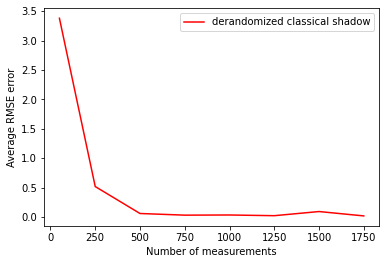

In [13]:
'''
EXPERIMENTS
'''

start_time = time.time()
rmse_errors = []




print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(observables_xyz, num_operators, 
                                                                      system_size, weight=absolute_coefficients)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        
        expectation_value = ground_state_energy_from_shadow(derandomized_hamiltonian, result.raw_result.optimal_point)
        expectation_values.append(expectation_value)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='derandomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)




In [14]:
'''
ESTIMATE THE HAMILTONIAN ON OPTIMAL PARAMETERS
'''

qc = ansatz.bind_parameters(result.raw_result.optimal_point)
job_ham = estimator.run(qc, bkencoded_hamiltonian)
result_h = job_ham.result()
print(f">>> Expectation value of the Hamiltonian: {result_h.values[0]}")

expectation_values = []
for index, term in enumerate(bkencoded_hamiltonian.paulis):
    job = estimator.run(qc, term) 
    #print(f">>> Job ID: {job.job_id()}")
    #print(f">>> Job Status: {job.status()}")
    result2 = job.result()
    #print(f">>> {result2}")
    expval = result2.values[0]
    expectation_values.append(expval)
    print("  > Expectation value of {} with coeff {}: {}".format(term, bkencoded_hamiltonian.coeffs.real[index], expval))

total_expval = 0.0
for index, expval in enumerate(expectation_values):
    total_expval += expval * bkencoded_hamiltonian.coeffs.real[index]

print('>>> Total expectation value from summing up expectation values of all terms', total_expval)

>>> Expectation value of the Hamiltonian: -1.8499915033930974
  > Expectation value of IIIIIIII with coeff 1.528021059233263: 1.0
  > Expectation value of IIIIIIIZ with coeff -0.2722152573510043: -0.9966140064708805
  > Expectation value of IIIIIYYX with coeff 0.08812294324841621: 1.2304511747539746e-09
  > Expectation value of IIIIIXYY with coeff -0.0881229432484162: 2.286561540180927e-09
  > Expectation value of IIIIIIZZ with coeff -0.4051688984463242: 0.9966797534302095
  > Expectation value of IIIIZIXZ with coeff -0.05206368066441235: 0.00554487917780148
  > Expectation value of IIIIIZXI with coeff 0.05206368066441235: 0.005564465051990897
  > Expectation value of IIIIIZII with coeff -0.6893596033215879: 0.9999999842891071
  > Expectation value of IIIIZZZI with coeff -1.042222589081819: 0.9999825691824109
  > Expectation value of IIIZIIII with coeff -0.2722152573510046: -0.9966988007217842
  > Expectation value of IYYXIIII with coeff 0.08812294324841619: 0.00638567693790561
  > Exp

  > Expectation value of IIZZZIXZ with coeff 0.013600193664962224: 0.0055454912484867325
  > Expectation value of IIZZIZXI with coeff -0.013600193664962224: 0.005563620599028046
  > Expectation value of IYYZIYYZ with coeff 0.00902158336392249: -3.730965201661505e-09
  > Expectation value of IXXIIYYZ with coeff 0.00902158336392249: 6.143372770391684e-09
  > Expectation value of IYYZIXXI with coeff 0.00902158336392249: -2.649760173096372e-08
  > Expectation value of IXXIIXXI with coeff 0.00902158336392249: 3.31309308233044e-08
  > Expectation value of ZIXZZIZZ with coeff 0.013600193664962226: -0.0032565393745278117
  > Expectation value of IZXIIIZZ with coeff -0.013600193664962226: -0.003499368331684863
  > Expectation value of ZIXZIIXZ with coeff 0.01678377306392902: -1.713399865871128e-05
  > Expectation value of IZXIZIXZ with coeff -0.01678377306392902: -1.8414680344288478e-05
  > Expectation value of ZIXZZZXI with coeff -0.01678377306392902: -1.7046093833421985e-05
  > Expectation va